In [ ]:
import sys
import os
sys.path.append("../..")
from commembed.jupyter import *
import commembed.linalg as linalg
import commembed.dimens as dimens
import numpy as np
import pandas as pd
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import datetime
from tqdm.notebook import tqdm
tqdm.pandas()
import seaborn as sns
import matplotlib.gridspec as gridspec
import commembed.data as data
spark = data.spark_context()

%config InlineBackend.figure_format = 'retina'
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

%load_ext autoreload
%autoreload 2

In [2]:
embedding = load_embedding('reddit', 'master')
dimen_list = dimens.load_dimen_list('final')
scores = dimens.score_embedding(embedding, dimen_list)
plt.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['mathtext.fontset'] = 'custom'

In [3]:
def add_subplot_label(ax, label, x=-70, y=0): 
    ax.annotate(label, xy=(0, 1), xycoords='axes fraction',
      xytext=(x, y), textcoords='offset points',
      fontsize=16, fontweight='bold', va='top', ha='left')

In [5]:
def adjust_date_ticks(ax, months, do_y=True):
    
    ticks = [(x, label.split("-")[0]) for x, label in enumerate(months) if label.endswith("-01")]
    if do_y:
        ax.set_yticks([x[0] for x in ticks])
        ax.set_yticklabels([x[1] for x in ticks])
    ax.set_xticks([x[0] for x in ticks])
    ax.set_xticklabels([x[1] for x in ticks], rotation=90)


In [8]:
cat_months = ["%04d-%02d" % (year, month) for year in range(2014, 2019) for month in range(1, 13)]

heatmap max 0.084134


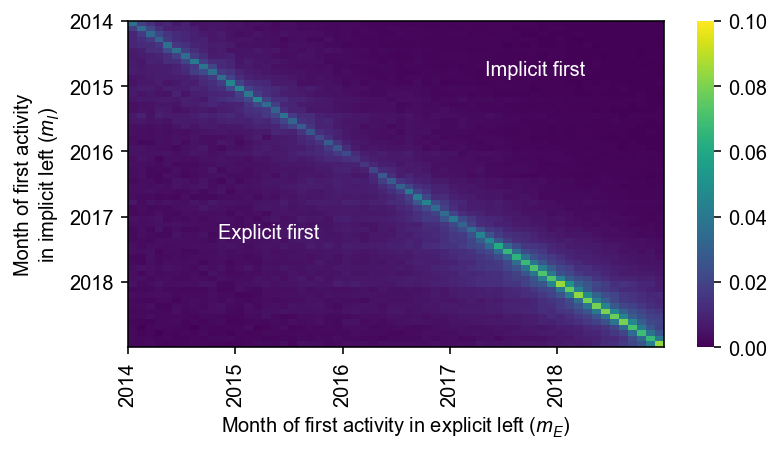

In [9]:
from matplotlib.patches import Rectangle


labels = {1:"explicit left", 2:"implicit left",
         4:"implicit right", 5:"explicit right"}

def render_cat_heatmap(fig, gs, cat1, cat2, partisan_dimen,sharey=None,cbar_ax=None, dem=True,vmax=0.1):
    ax = fig.add_subplot(gs, sharey=sharey)
    
    heatmap_data = pd.read_csv('../06_polarization/heatmap_%s_to_%s_%s.csv' % (cat1, cat2, partisan_dimen), index_col=0)
    
    heatmap_data = heatmap_data.loc[cat_months, cat_months]
    
    print("heatmap max %f" % np.amax(heatmap_data.fillna(0).values))
    
    
    sns.heatmap(heatmap_data, ax=ax, cmap='viridis', cbar_ax=cbar_ax, vmin=0, vmax=vmax)
    #ax.invert_yaxis()
    ax.set_facecolor(plt.cm.viridis(0))
    ax.set_xlabel("Month of first activity in %s ($m_E$)" % labels[int(cat2)])
    ax.set_ylabel("Month of first activity\nin %s ($m_I$)" % labels[int(cat1)])
    
    #ax.plot([0, len(cat_months)], [0,len(cat_months)], color='white', linewidth=0.5, linestyle='--')
    
    
    adjust_date_ticks(ax, heatmap_data.index)
    
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        
    if dem:
        ax.annotate("Implicit first", (40,10), color='white')
        ax.annotate("Explicit first", (10,40), color='white')
    
    return ax
    
    
fig = plt.figure(figsize=(6,3))
render_cat_heatmap(fig, gridspec.GridSpec(1, 1, figure=fig)[0,0], "2", "1", "partisan")
plt.show()

2->1 max value: 0.270803


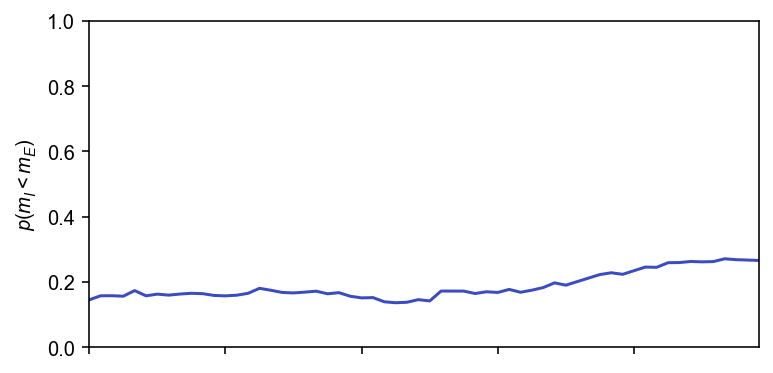

In [10]:

def render_activity_line(fig, gs, cat1, cat2, partisan_dimen, sharex=None, dem=True, label=False):
    ax = fig.add_subplot(gs, sharex=sharex)
    
    
    activity_data = pd.read_csv('../06_polarization/implicit_user_counts_cat_%s_to_%s_%s.csv' % (cat1, cat2,partisan_dimen), index_col=0)
    
    #ax.plot()
    
    activity_data = activity_data[~activity_data["month_cat_b"].isna()]
    activity_data = activity_data.sort_values("month_cat_b")
    activity_data = activity_data.set_index("month_cat_b").loc[cat_months]
    
    c = matplotlib.cm.coolwarm(-1000 if dem else 1000)
    
    ax.plot(activity_data.index.values, activity_data["pct_cat_a_before"], c=c)
    ax.set_ylim(0, 1)
    ax.set_ylabel("$p(m_I < m_E)$")
    
    print("%s->%s max value: %f" % (cat1, cat2, np.amax(activity_data["pct_cat_a_before"])))
    
    
    adjust_date_ticks(ax, activity_data.index, do_y=False)
    ax.set_xlim(0, len(activity_data)-1)
    ax.set_xticklabels([])
        
    if label:
        add_subplot_label(ax, "b")
    
    return ax
    
fig = plt.figure(figsize=(6,3))
render_activity_line(fig, gridspec.GridSpec(1, 1, figure=fig)[0,0], "2", "1", "partisan")
plt.show()

In [ ]:
from matplotlib.transforms import Bbox

def nudge_axis(ax, x, y):
    sp_ax = ax.get_position()
    ax.set_position(Bbox(sp_ax.get_points() + [[x, y], [x, y]]))
    
def shrink_axis(ax, x, y):
    sp_ax = ax.get_position()
    ax.set_position(Bbox(sp_ax.get_points() + [[x, y], [0, 0]]))

heatmap max 0.084134
heatmap max 0.066872
2->1 max value: 0.270803
4->5 max value: 0.270236


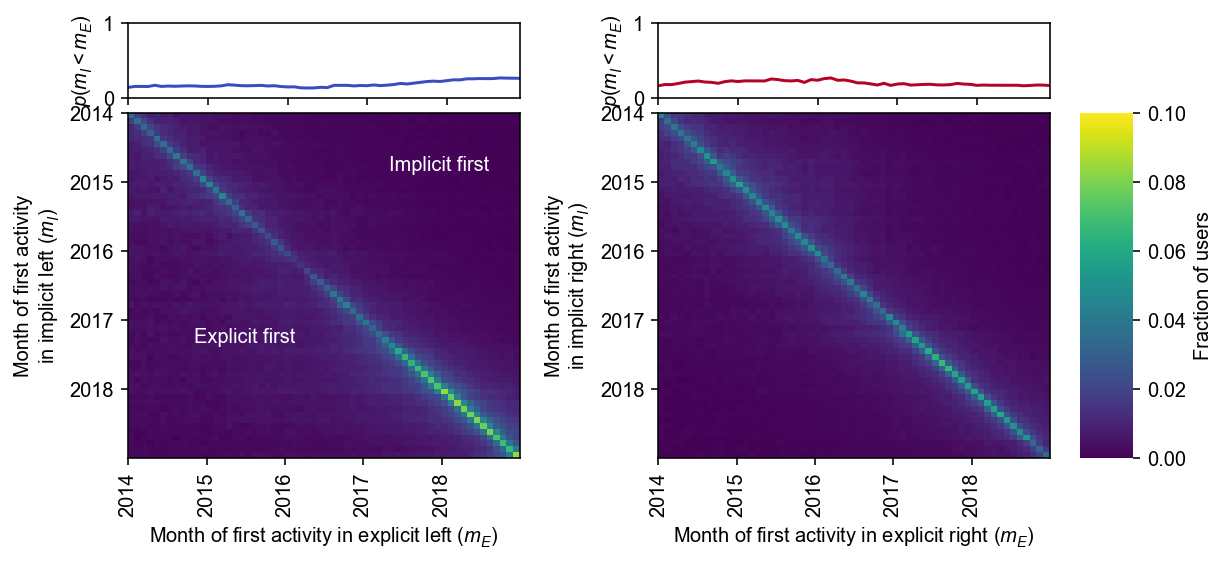

In [12]:
            
from matplotlib.transforms import Bbox

def render_implicit_polarization_figure(partisan_dimen):

    fig = plt.figure(figsize=(9,4))

    gs0 = gridspec.GridSpec(5, 10, figure=fig)


    gs3 = gs0[1:, 0:4]
    gs4 = gs0[1:, 5:9]
    gs_colorbar = gs0[1:, 9]
    cbar_ax = fig.add_subplot(gs_colorbar)

    gs_dem_line = gs0[0:1, 0:4]
    gs_rep_line = gs0[0:1, 5:9]

    # TODO COLORBARS ARE NOT SYNC'D


    vmax = 0.15 if partisan_dimen == "partisan_b" else 0.1
    ax_dem_heatmap = render_cat_heatmap(fig, gs3, "2", "1", partisan_dimen, cbar_ax=cbar_ax, vmax=vmax)
    ax_rep_heatmap = render_cat_heatmap(fig, gs4, "4", "5", partisan_dimen, cbar_ax=cbar_ax, dem=False, vmax=vmax)

    cbar_ax.set_ylabel("Fraction of users")
    ax_dem_line = render_activity_line(fig, gs_dem_line, "2", "1", partisan_dimen)
    ax_rep_line = render_activity_line(fig, gs_rep_line, "4", "5", partisan_dimen, dem=False)
    
    nudge_amt = 0.015
    nudge_axis(ax_rep_heatmap, nudge_amt, 0)
    nudge_axis(ax_rep_line, nudge_amt, 0)
    shrink_axis(cbar_ax, nudge_amt+0.01, 0)
    
    return fig, []
    
render_implicit_polarization_figure("partisan")
plt.show()

In [ ]:
save_paper_figure(render_implicit_polarization_figure("partisan"), "fig_A_5_implicit_polarization", filetype='tiff')